<h2> Proyecto final</h2>

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

In [2]:
def TS2DBS(TS, m, tau, delta):
    N = len(TS)
    DBSize = N-delta-(m-1)*tau
    DB = np.array([TS[slice(i,i+m*tau,tau)] for i in range(DBSize)])
    Y = np.array([TS[slice(i+m*tau,i+m*tau+delta,tau)] for i in range(DBSize)])
    return DB,Y


In [3]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')

  #plt.ylim([0,20])
  plt.legend(loc="upper right")

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Precisión')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train ACC')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val ACC')
  #plt.ylim([0,20])
  plt.legend(loc="lower right")
  
  plt.show()

In [4]:
m = 64
tau = 1
delta = 2

<h3>1) Series de tiempo y MLP </h3>

Los datos de la serie de tiempo se encuentran en un archivo csv, por lo cual se utiliza pandas para leer los datos. Posteriormente se realiza una revición a los datos por medio del metodo info() con la finalidad de encontrar valores nulos

In [5]:
TS = pd.read_csv('TimesSeries\Electric_Production.csv')

In [6]:
TS.info() # Se reviza que la serie de tiempo no tenga nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
DATE     397 non-null object
Value    397 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [7]:
serie = TS.Value

In [8]:
serie.mean()

88.84721763224182

In [9]:
serie.max()

129.4048

In [10]:
serie.min()

55.3151

In [11]:
serie.std()

15.387833664730902

Una vez que se ha revizado que la serie de tiempo no tiene valores nulos se aplica una estandarizacion a los datos, con la finalidad de mejorar el entrenamiento de la red neuronal MLP. Para realizar esta estandarizacion se utiliza la clase StandardScaler de Sklearn.

In [12]:
serie = (serie - serie.mean()) / serie.std()

In [13]:
serie.min()

-2.179131797421091

Después de que se estandarizo para mantenerlo alrededor del cero, se aplica la función TS2DBS para obtener una base de datos a partir de la serie de tiempo.

In [14]:
X,y = TS2DBS(serie,m,tau,delta)

In [15]:
X.shape

(332, 64)

In [16]:
y.shape

(332, 2)

Para terminar con el tratamiento de los datos se divide en train y test. Posteriormente del train se obtiene el validation

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [18]:
X_train.shape

(232, 64)

In [19]:
X_test.shape

(100, 64)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [21]:
X_train.shape

(185, 64)

In [22]:
X_val.shape

(47, 64)

In [23]:
X_test

array([[-1.22078377, -1.51010325, -1.86437014, ..., -0.93058698,
        -1.24794159, -1.40817857],
       [ 0.9080669 ,  1.68052131,  1.60832141, ...,  1.66966208,
         1.73310181,  0.90438217],
       [-0.73369117, -1.00613367, -1.41002419, ..., -0.12422916,
        -0.7555201 , -0.79053478],
       ...,
       [ 0.12805457,  0.2087027 ,  0.78766008, ...,  0.25429716,
         0.79886374,  1.57192253],
       [-1.28794072, -0.9974125 , -0.28147676, ..., -0.44206467,
         0.21145162,  0.38633004],
       [-1.29828656, -1.22046534, -1.60725143, ..., -0.7999708 ,
        -1.07182843, -1.28794072]])

<h3>Red Neuronal MLP</h3>

Primeramente se crea la arquitectura de la red neuronal, para  esto se utiliza tensorflow en combinacion con keras

In [24]:
inputs = keras.Input(shape=(m))
x = layers.Dense(64, activation='sigmoid')(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(delta, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='forecasting')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [25]:
model.summary()

Model: "forecasting"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 46,018
Trainable params: 46,018
Non-trainable params: 0
_________________________________________________________________


Una vez que el modelo esta creado se compila y se entrena

In [26]:
model.compile(loss="mean_squared_error", optimizer="sgd", metrics=['accuracy'])

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    batch_size=64,
                    callbacks=[callback],
                    epochs=200,
                    validation_data=(X_val, y_val))

test_scores = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Train on 185 samples, validate on 47 samples
Epoch 1/200
185/185 [==============================] - 0s 1ms/sample - loss: 0.7723 - acc: 0.4811 - val_loss: 0.5555 - val_acc: 0.4468
Epoch 2/200
185/185 [==============================] - 0s 59us/sample - loss: 0.6534 - acc: 0.5784 - val_loss: 0.4876 - val_acc: 0.6596
Epoch 3/200
185/185 [==============================] - 0s 65us/sample - loss: 0.5861 - acc: 0.7189 - val_loss: 0.4412 - val_acc: 0.7872
Epoch 4/200
185/185 [==============================] - 0s 70us/sample - loss: 0.5375 - acc: 0.8486 - val_loss: 0.4039 - val_acc: 0.8723
Epoch 5/200
185/185 [==============================] - 0s 59us/sample - loss: 0.4943 - acc: 0.8703 - val_loss: 0.3693 - val_acc: 0.8936
Epoch 6/200
185/185 [==============================] - 0s 59us/sample - loss: 0.4543 - acc: 0.8865 - val_loss: 0.3381 - val_acc: 0.8936
Epoch 7/200
185/185 [==============================] - 0s 62us/sample - loss: 0.4165 - acc: 0.8865 - val_loss: 0.3104 - val_acc: 0.8936
Epoc

185/185 [==============================] - 0s 54us/sample - loss: 0.0687 - acc: 0.9081 - val_loss: 0.0515 - val_acc: 0.9149
Epoch 61/200
185/185 [==============================] - 0s 70us/sample - loss: 0.0676 - acc: 0.9081 - val_loss: 0.0508 - val_acc: 0.9149
Epoch 62/200
185/185 [==============================] - 0s 65us/sample - loss: 0.0669 - acc: 0.9081 - val_loss: 0.0505 - val_acc: 0.9149
Epoch 63/200
185/185 [==============================] - 0s 59us/sample - loss: 0.0666 - acc: 0.9081 - val_loss: 0.0501 - val_acc: 0.9149
Epoch 64/200
185/185 [==============================] - 0s 49us/sample - loss: 0.0668 - acc: 0.9081 - val_loss: 0.0502 - val_acc: 0.9149
Epoch 65/200
185/185 [==============================] - 0s 59us/sample - loss: 0.0657 - acc: 0.9081 - val_loss: 0.0497 - val_acc: 0.9149
Epoch 66/200
185/185 [==============================] - 0s 70us/sample - loss: 0.0649 - acc: 0.9081 - val_loss: 0.0501 - val_acc: 0.9149
Epoch 67/200
185/185 [==============================] 

Epoch 120/200
185/185 [==============================] - 0s 65us/sample - loss: 0.0510 - acc: 0.9081 - val_loss: 0.0421 - val_acc: 0.9149
Epoch 121/200
185/185 [==============================] - 0s 65us/sample - loss: 0.0510 - acc: 0.9135 - val_loss: 0.0421 - val_acc: 0.9149
Epoch 122/200
185/185 [==============================] - 0s 59us/sample - loss: 0.0513 - acc: 0.9135 - val_loss: 0.0426 - val_acc: 0.9149
Epoch 123/200
185/185 [==============================] - 0s 54us/sample - loss: 0.0516 - acc: 0.9081 - val_loss: 0.0424 - val_acc: 0.9149
Epoch 124/200
185/185 [==============================] - 0s 59us/sample - loss: 0.0507 - acc: 0.9135 - val_loss: 0.0417 - val_acc: 0.9149
Epoch 125/200
185/185 [==============================] - 0s 75us/sample - loss: 0.0503 - acc: 0.9081 - val_loss: 0.0416 - val_acc: 0.9149
Epoch 126/200
185/185 [==============================] - 0s 59us/sample - loss: 0.0503 - acc: 0.9081 - val_loss: 0.0418 - val_acc: 0.9149
Epoch 127/200
185/185 [===========

185/185 [==============================] - 0s 70us/sample - loss: 0.0446 - acc: 0.9135 - val_loss: 0.0376 - val_acc: 0.9149
Epoch 180/200
185/185 [==============================] - 0s 70us/sample - loss: 0.0446 - acc: 0.9135 - val_loss: 0.0375 - val_acc: 0.9149
Epoch 181/200
185/185 [==============================] - 0s 70us/sample - loss: 0.0441 - acc: 0.9135 - val_loss: 0.0375 - val_acc: 0.9149
Epoch 182/200
185/185 [==============================] - 0s 59us/sample - loss: 0.0450 - acc: 0.9135 - val_loss: 0.0386 - val_acc: 0.9149
Epoch 183/200
185/185 [==============================] - 0s 65us/sample - loss: 0.0443 - acc: 0.9135 - val_loss: 0.0372 - val_acc: 0.9149
Epoch 184/200
185/185 [==============================] - 0s 59us/sample - loss: 0.0442 - acc: 0.9135 - val_loss: 0.0373 - val_acc: 0.9149
Epoch 185/200
185/185 [==============================] - 0s 59us/sample - loss: 0.0439 - acc: 0.9135 - val_loss: 0.0374 - val_acc: 0.9149
Epoch 186/200
185/185 [=========================

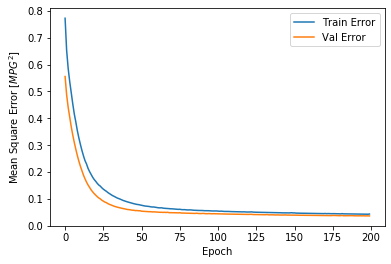

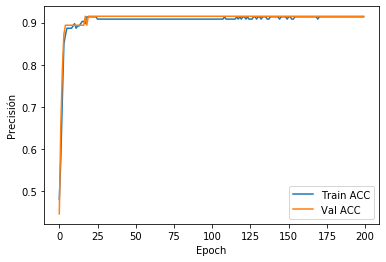

In [31]:
plot_history(history)

In [33]:
muestra = X_test[0]
#muestra.reshape(1,64)

In [34]:
y_test[0:4]

array([[-1.14632235, -0.7368885 ],
       [ 0.17153047,  0.26272589],
       [-0.44948612, -0.1875909 ],
       [ 0.75885811,  1.43639988]])

In [35]:
y_predic= model.predict(X_test)

In [36]:
r = y_test - y_predic

In [37]:
r.mean()

0.009767784333851576

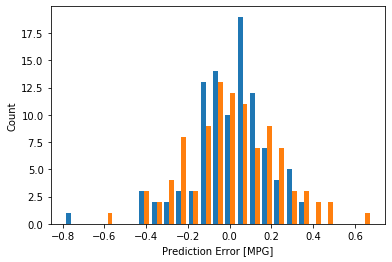

In [38]:

plt.hist(r, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

<h3>Guardar el modelo entrenado </h3>

El modelo que fue generado atravez del entrenamiento es guardado con la finalidad de utilizarlo sin la necesidad de volver a entrenar

In [40]:
model.save('modelo_serie_electrica.h5')